Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Fine-Tuning VISTA3D Model for Hugging Face Pipeline

This tutorial will illustrate how to fine-tune a VISTA3D model using the Decathlon spleen dataset and integrate it into an existing VISTA3D Hugging Face pipeline.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](../figures/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
from monai.transforms import (
    LoadImage,
    ToNumpy,
)
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from huggingface_hub import snapshot_download

print_config()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.0
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Download the VISTA3D hugging face pipeine

The VISTA3D-HF is an open-source example model for VISTA3D, available on the Hugging Face Hub for public access. It can be downloaded using the Hugging Face API.

In [ ]:
VISTA3D_HF_REPO = "MONAI/VISTA3D-HF"
snapshot_download(VISTA3D_HF_REPO, local_dir=".")

## Define utility functions

In [7]:
numpy_transform = ToNumpy()
loader = LoadImage()


def convert_to_numpy(input):
    numpy_output = numpy_transform(input)
    numpy_output = np.squeeze(numpy_output, axis=0)
    return numpy_output

## Inference on the test set with VISTA3D-HF model

Since the VISTA3D-HF model is a fundation model for 3D medical images, we can directly run this model on the spleen dataset.

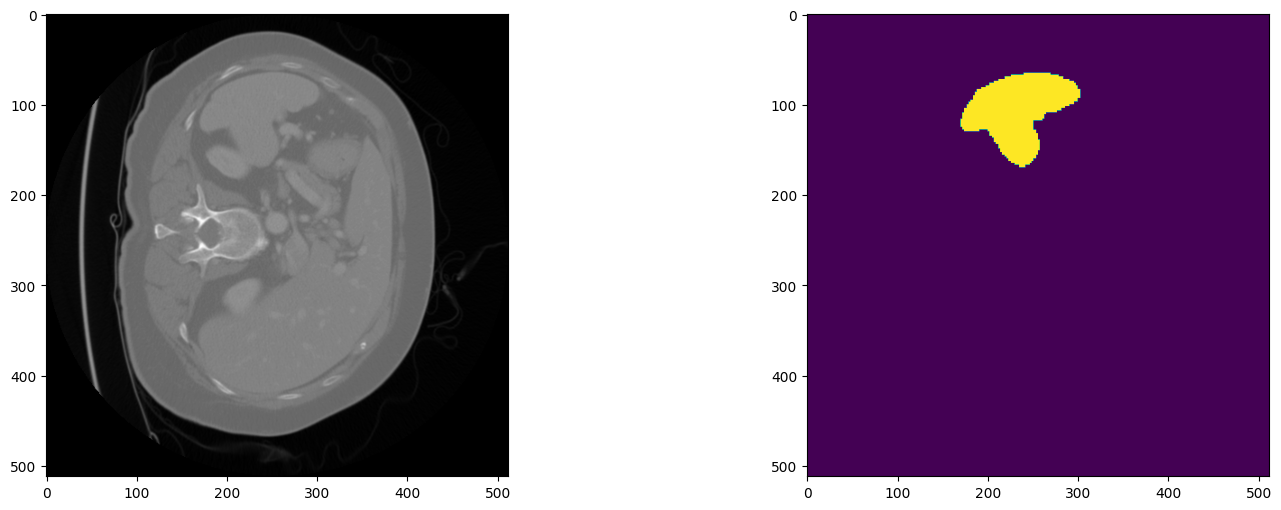

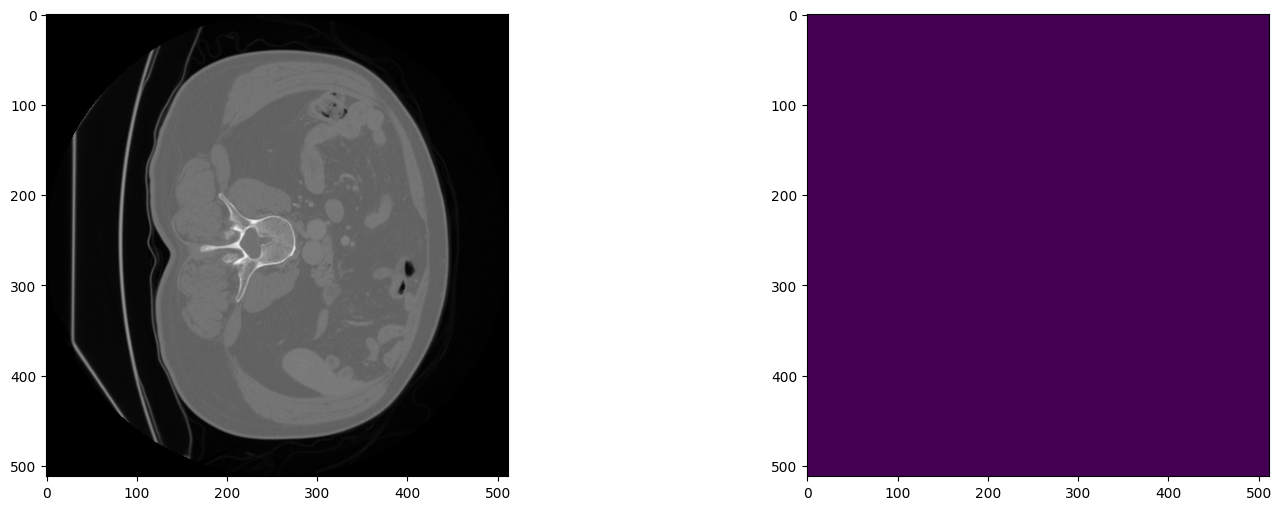

In [8]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
test_data = [{"image": image, "label_prompt": [3]} for image in test_images]

# This is from the vista3d hugging face model. Can only be imported after downloading.
from hugging_face_pipeline import HuggingFacePipelineHelper  # noqa: E402

pipeline_helper = HuggingFacePipelineHelper("vista3d")
pipeline = pipeline_helper.init_pipeline("./vista3d_pretrained_model", device=torch.device("cuda:0"))
test_data = test_data[:2]
with torch.no_grad():
    test_outputs = pipeline(test_data, save_output=False)
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Inference on the test set with the fune-tuned pipeline

In real-world applications, a foundation model typically requires tuning with private datasets. In this section, we will demonstrate how to integrate a fine-tuned model into the Hugging Face pipeline.

The fine-tuning process for the VISTA3D model is detailed in the [VISTA3D fine-tuning tutorial](https://github.com/Project-MONAI/tutorials/blob/main/vista_3d/vista3d_spleen_finetune.ipynb). Please refer to it for instructions on training a fine-tuned model. After completing the fine-tuning, replace the `fine_tuned_model_path` variable below with the path to your model to run inference using the new model weights.

In [9]:
fine_tuned_model_path = os.path.join(root_dir, "best_metric_model.pth")

# These three are from the vista3d hugging face model. Can only be imported after downloading.
from vista3d_config import VISTA3DConfig  # noqa: E402
from vista3d_model import VISTA3DModel  # noqa: E402
from vista3d_pipeline import VISTA3DPipeline  # noqa: E402

config = VISTA3DConfig()
vista3d_hf_model = VISTA3DModel(config)
vista3d_hf_model.network.load_state_dict(torch.load(fine_tuned_model_path, weights_only=True))
# Save model to hugging face format so that it can be loaded by the from_pretrained API
hugging_face_model_path = os.path.join(root_dir, "huggging_face")
os.makedirs(hugging_face_model_path, exist_ok=True)
vista3d_hf_model.save_pretrained(hugging_face_model_path)
vista3d_ft_pipeline = VISTA3DPipeline(vista3d_hf_model, device=torch.device("cuda"))

### Check the inference results of the fine-tuned model

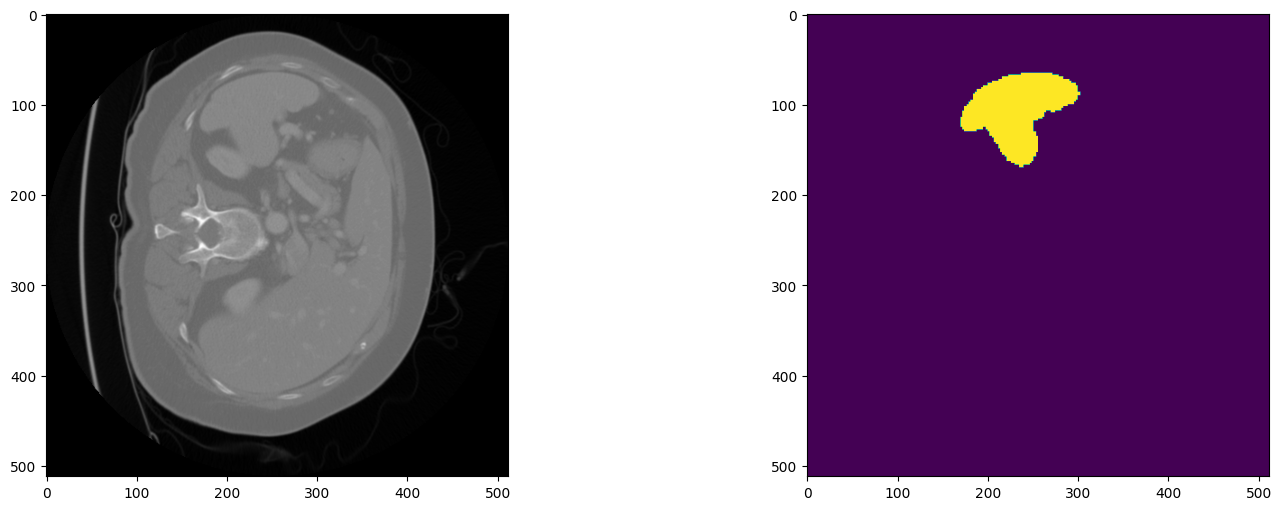

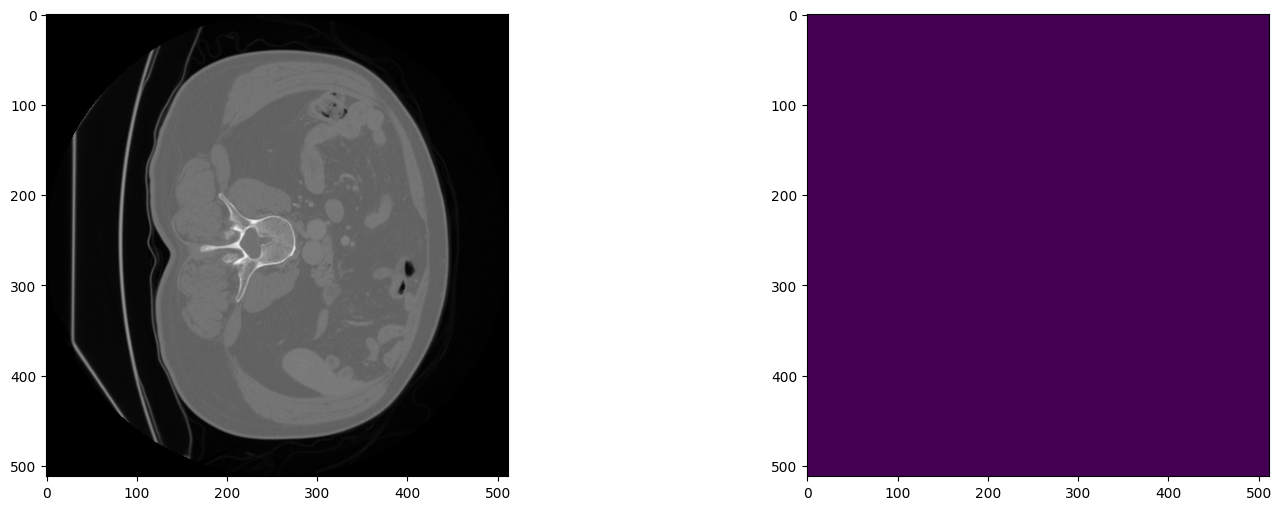

In [10]:
# Visualize the results of the fine-tuned model.
with torch.no_grad():
    test_outputs = vista3d_ft_pipeline(test_data, save_output=False)
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)